In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from krippendorff import alpha

sns.set_theme(style="whitegrid", context="paper", font_scale=1.3)

In [2]:
res = pd.read_csv("results.csv", sep=";", header=None)

In [3]:
res_t = res.T
res_t.columns = ["Run", "Prompt", "Model", "Score1", "Score2", "Score3", "Score4"]
res_t["Score1"] = res_t["Score1"].astype(float)
res_t["Score2"] = res_t["Score2"].astype(float)
res_t["Score3"] = res_t["Score3"].astype(float)
res_t["Score4"] = res_t["Score4"].astype(float)

res_t["Score"] = res_t[["Score1", "Score2", "Score3", "Score4"]].mean(axis=1)
res_t["Prompt"] = res_t["Prompt"].str.strip()

## Krippendorff alpha

In [4]:
kr = res.drop([0,1,2])
kr = kr.astype(float)

alpha(kr.values, level_of_measurement="ordinal", value_domain=[1,2,3,4,5])

0.4650998138665381

## RQ 1

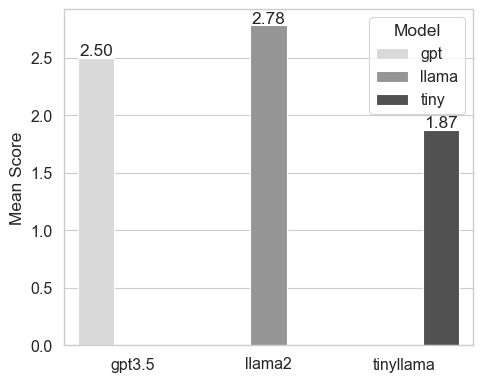

In [5]:
rq1 = res_t.pivot_table(
    index="Run", columns=["Model"], values=["Score"], aggfunc="mean"
)
fig, ax = plt.subplots(figsize=(5,4))
ax = sns.barplot(data=rq1.agg("mean").reset_index(), x="Model", y=0, hue='Model', palette="Greys")
plt.ylabel("Mean Score")
plt.xlabel("")
plt.xticks([0, 1, 2], ["gpt3.5", "llama2", "tinyllama"])

for p in ax.patches:
    if not p.get_height() == 0.0:
        ax.annotate(
            f"{p.get_height():.2f}",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 5),
            textcoords="offset points",
        )
    # p.set_hatch(hatch)
plt.tight_layout()
plt.savefig("figures/rq1.pdf")

## RQ 2

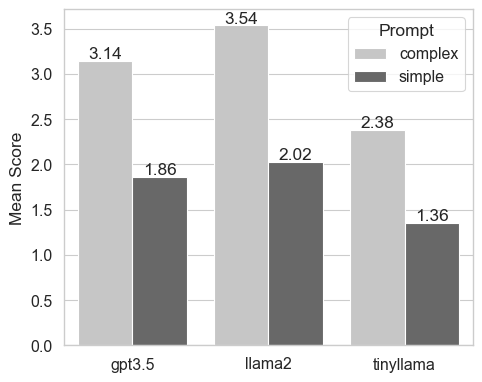

In [13]:
rq2 = res_t.pivot_table(
    index="Run", columns=["Model", "Prompt"], values=["Score"], aggfunc="mean"
)
fig, ax = plt.subplots(figsize=(5,4))
ax = sns.barplot(
    data=rq2.agg("mean").reset_index(), 
    x="Model", 
    y=0, 
    hue="Prompt",
    palette="Greys")
# show values on top of bars
for p in ax.patches:
    if not p.get_height()==0.0:
        ax.annotate(
            f"{p.get_height():.2f}",
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 5),
            textcoords="offset points",
        )
sns.move_legend(ax, "upper right", frameon=True)
plt.ylabel("Mean Score")
plt.xlabel("")
plt.xticks([0, 1, 2], ["gpt3.5", "llama2", "tinyllama"])
plt.tight_layout()
plt.savefig("figures/rq2.pdf")

### Statistical Test

In [18]:
gpt_simple = res_t[(res_t["Model"] == "gpt")&(res_t["Prompt"]=='simple')]["Score"]
gpt_complex = res_t[(res_t["Model"] == "gpt") & (res_t["Prompt"] == "complex")][
    "Score"
]

llama_simple = res_t[(res_t["Model"] == "llama") & (res_t["Prompt"] == "simple")]["Score"]
llama_complex = res_t[(res_t["Model"] == "llama") & (res_t["Prompt"] == "complex")][
    "Score"
]

tinyllama_simple = res_t[(res_t["Model"] == "tiny") & (res_t["Prompt"] == "simple")]["Score"]
tinyllama_complex = res_t[(res_t["Model"] == "tiny") & (res_t["Prompt"] == "complex")][
    "Score"
]

#### Shapiro-Wilk Test for Normality

In [44]:
stats.shapiro(gpt_simple)

ShapiroResult(statistic=0.9291981888088285, pvalue=0.13264979282535594)

In [45]:
stats.shapiro(gpt_complex)

NormaltestResult(statistic=0.5566427088632463, pvalue=0.7570534999230176)

In [14]:
stats.shapiro(llama_simple)

ShapiroResult(statistic=0.7929722075919757, pvalue=0.0005132961024135242)

In [37]:
stats.shapiro(llama_complex)

ShapiroResult(statistic=0.8750517254391459, pvalue=0.011839767596732666)

In [49]:
stats.shapiro(tinyllama_simple)

ShapiroResult(statistic=0.8472109834123442, pvalue=0.003804282814515208)

In [47]:
stats.shapiro(tinyllama_complex)

ShapiroResult(statistic=0.9416245204146176, pvalue=0.23459611852539386)

### Paired t-test for gpt distribution

In [78]:
stats.ttest_rel(gpt_simple, gpt_complex)

TtestResult(statistic=-12.044692892127706, pvalue=1.273080166945614e-10, df=20)

### Wilcoxon Signed-Rank Test for llama distribution

In [50]:
stats.wilcoxon(llama_simple, llama_complex)

WilcoxonResult(statistic=2.0, pvalue=2.86102294921875e-06)

### Wilcoxon Signed-Rank Test for tinyllama distribution

In [51]:
stats.wilcoxon(tinyllama_simple, tinyllama_complex)

WilcoxonResult(statistic=1.5, pvalue=0.00010703333092589676)

## RQ 3

In [52]:
rq3 = res_t.pivot_table(columns=["Model", "Prompt", "Run"], values=["Score"], aggfunc="mean")

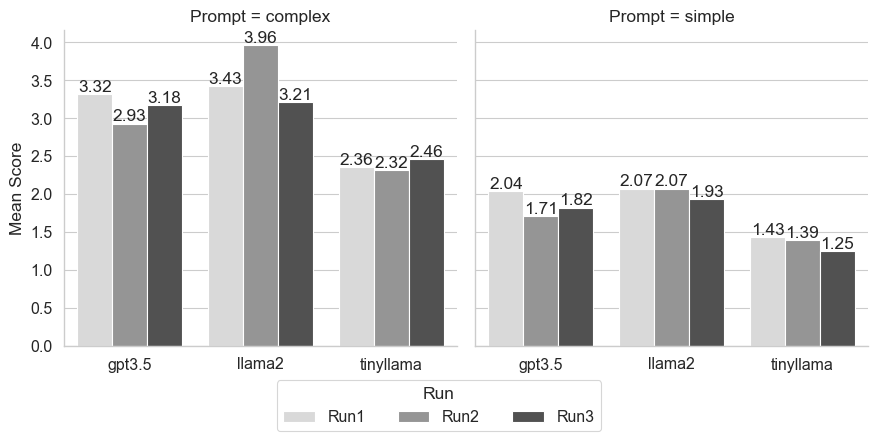

In [53]:
grid = sns.catplot(
    data=rq3.aggregate("mean").reset_index(),
    x="Model",
    y=0,
    hue="Run",
    col="Prompt",
    kind="bar",
    height=4,
    palette="Greys",
)
grid.set_axis_labels("", "Mean Score")

# show values on top of bars
for ax in grid.axes.flat:
    for p in ax.patches:
        if not p.get_height()==0.0:
            ax.annotate(
                f"{p.get_height():.2f}",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center",
                va="center",
                xytext=(0, 5),
                textcoords="offset points",
            )
sns.move_legend(grid, "lower center", ncol=3, frameon=True, bbox_to_anchor=(0.5, -0.12))
grid.set_xticklabels(["gpt3.5", "llama2", "tinyllama"])
plt.tight_layout()
plt.savefig("figures/rq3.pdf", bbox_inches="tight")

### Statistical Test

#### GPT

In [66]:
gpt1_s = res_t[
    (res_t["Model"] == "gpt")
    & (res_t["Prompt"] == "simple")
    & (res_t["Run"] == "Run1")
]["Score"]

gpt2_s = res_t[
    (res_t["Model"] == "gpt") & (res_t["Prompt"] == "simple") & (res_t["Run"] == "Run2")
]["Score"]

gpt3_s = res_t[
    (res_t["Model"] == "gpt") & (res_t["Prompt"] == "simple") & (res_t["Run"] == "Run3")
]["Score"]

In [60]:
stats.shapiro(gpt1_s)

ShapiroResult(statistic=0.9202476025992193, pvalue=0.47131835286954893)

In [61]:
stats.shapiro(gpt2_s)

ShapiroResult(statistic=0.8180887757529729, pvalue=0.061550147978133345)

In [62]:
stats.shapiro(gpt3_s)

ShapiroResult(statistic=0.8333845641645437, pvalue=0.08613669465637135)

In [67]:
stats.kruskal(gpt1_s, gpt2_s, gpt3_s)

KruskalResult(statistic=3.5585138088615196, pvalue=0.1687635081004064)

In [68]:
gpt1_c = res_t[
    (res_t["Model"] == "gpt")
    & (res_t["Prompt"] == "complex")
    & (res_t["Run"] == "Run1")
]["Score"]

gpt2_c = res_t[
    (res_t["Model"] == "gpt") & (res_t["Prompt"] == "complex") & (res_t["Run"] == "Run2")
]["Score"]

gpt3_c = res_t[
    (res_t["Model"] == "gpt") & (res_t["Prompt"] == "complex") & (res_t["Run"] == "Run3")
]["Score"]

In [69]:
stats.shapiro(gpt1_c)

ShapiroResult(statistic=0.9390478359216043, pvalue=0.6301591986192884)

In [70]:
stats.shapiro(gpt2_c)

ShapiroResult(statistic=0.9197901633247106, pvalue=0.467763713015455)

In [71]:
stats.shapiro(gpt3_c)

ShapiroResult(statistic=0.8180887757529729, pvalue=0.061550147978133345)

In [72]:
stats.kruskal(gpt1_c, gpt2_c, gpt3_c)

KruskalResult(statistic=2.4791626284163777, pvalue=0.28950540436722366)

#### LLAMA

In [85]:
llama1_c = res_t[
    (res_t["Model"] == "llama")
    & (res_t["Prompt"] == "complex")
    & (res_t["Run"] == "Run1")
]["Score"]

llama2_c = res_t[
    (res_t["Model"] == "llama") & (res_t["Prompt"] == "complex") & (res_t["Run"] == "Run2")
]["Score"]

llama3_c = res_t[
    (res_t["Model"] == "llama") & (res_t["Prompt"] == "complex") & (res_t["Run"] == "Run3")
]["Score"]

In [86]:
stats.shapiro(llama1_c)

ShapiroResult(statistic=0.810770490809439, pvalue=0.05226521648375003)

In [87]:
stats.shapiro(llama2_c)

ShapiroResult(statistic=0.8585659395402375, pvalue=0.1469708548930031)

In [88]:
stats.shapiro(llama3_c)

ShapiroResult(statistic=0.9222174366916898, pvalue=0.4868164506502304)

In [89]:
stats.kruskal(llama1_c, llama2_c, llama3_c)

KruskalResult(statistic=5.048393341076273, pvalue=0.08012265182731258)

In [90]:
llama1_s = res_t[
    (res_t["Model"] == "llama")
    & (res_t["Prompt"] == "simple")
    & (res_t["Run"] == "Run1")
]["Score"]

llama2_s = res_t[
    (res_t["Model"] == "llama") & (res_t["Prompt"] == "simple") & (res_t["Run"] == "Run2")
]["Score"]

llama3_s = res_t[
    (res_t["Model"] == "llama") & (res_t["Prompt"] == "simple") & (res_t["Run"] == "Run3")
]["Score"]

In [91]:
stats.shapiro(llama1_s)

ShapiroResult(statistic=0.8808910124677423, pvalue=0.23043263529734154)

In [92]:
stats.shapiro(llama2_s)

ShapiroResult(statistic=0.6003990298280553, pvalue=0.0002751787013147552)

In [93]:
stats.shapiro(llama3_s)

ShapiroResult(statistic=0.8693003412510614, pvalue=0.18302792575851945)

In [94]:
stats.kruskal(llama1_s, llama2_s, llama3_s)

KruskalResult(statistic=1.331953071083522, pvalue=0.5137715664600289)

#### TinyLLAMA

In [96]:
llama1_c = res_t[
    (res_t["Model"] == "tiny")
    & (res_t["Prompt"] == "complex")
    & (res_t["Run"] == "Run1")
]["Score"]

llama2_c = res_t[
    (res_t["Model"] == "tiny") & (res_t["Prompt"] == "complex") & (res_t["Run"] == "Run2")
]["Score"]

llama3_c = res_t[
    (res_t["Model"] == "tiny") & (res_t["Prompt"] == "complex") & (res_t["Run"] == "Run3")
]["Score"]

In [97]:
stats.shapiro(llama1_c)

ShapiroResult(statistic=0.7818608985050479, pvalue=0.02697561301354718)

In [98]:
stats.shapiro(llama2_c)

ShapiroResult(statistic=0.8927231700504343, pvalue=0.2891716366486139)

In [99]:
stats.shapiro(llama3_c)

ShapiroResult(statistic=0.9419167262356124, pvalue=0.6560406554251688)

In [100]:
stats.kruskal(llama1_c, llama2_c, llama3_c)

KruskalResult(statistic=0.2809364548495063, pvalue=0.8689512733138968)

In [101]:
llama1_s = res_t[
    (res_t["Model"] == "tiny")
    & (res_t["Prompt"] == "simple")
    & (res_t["Run"] == "Run1")
]["Score"]

llama2_s = res_t[
    (res_t["Model"] == "tiny") & (res_t["Prompt"] == "simple") & (res_t["Run"] == "Run2")
]["Score"]

llama3_s = res_t[
    (res_t["Model"] == "tiny") & (res_t["Prompt"] == "simple") & (res_t["Run"] == "Run3")
]["Score"]

In [102]:
stats.shapiro(llama1_s)

ShapiroResult(statistic=0.8931814966404188, pvalue=0.2916735077550582)

In [103]:
stats.shapiro(llama2_s)

ShapiroResult(statistic=0.8877086631182824, pvalue=0.2629231696569212)

In [104]:
stats.shapiro(llama3_s)

ShapiroResult(statistic=0.749640746600885, pvalue=0.012578565610532373)

In [105]:
stats.kruskal(llama1_s, llama2_s, llama3_s)

KruskalResult(statistic=1.4444665209616552, pvalue=0.48566642430653717)

### Cosine Similarity

In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import os

#### GPT

In [115]:
vectorizer = TfidfVectorizer()
sim_gpt = []
for file1 in os.listdir("explanation_human/gpt/run_1/"):
  files = []
  files.append(open("explanation_human/gpt/run_1/"+file1).read())
  for file2 in os.listdir("explanation_human/gpt/run_2/"):
    if file1 == file2:
      files.append(open("explanation_human/gpt/run_2/"+file2).read())
  for file3 in os.listdir("explanation_human/gpt/run_3/"):
    if file1 == file3:
      files.append(open("explanation_human/gpt/run_3/"+file3).read())
  X = vectorizer.fit_transform(files)
  sim_gpt.append(cosine_similarity(X)[0][1])

In [116]:
sim_gpt

[0.8191260975636787,
 0.5436381449755769,
 0.9151212505098925,
 0.7472616364426824,
 0.8357097071166534,
 0.8568714558825389,
 0.7122829225119784,
 0.7038957477774848,
 0.6875479970008918,
 0.7958812572963718,
 0.6727763060219835,
 0.5983656848422394,
 0.8793003440565954,
 0.5703945225308795]

#### LLAMA

In [117]:
vectorizer = TfidfVectorizer()
sim_llama = []
for file1 in os.listdir("explanation_human/llama2_0"):
    files = []
    files.append(open("explanation_human/llama2_0/" + file1).read())
    for file2 in os.listdir("explanation_human/llama2_1"):
        if file1 == file2:
            files.append(open("explanation_human/llama2_1/" + file2).read())
    for file3 in os.listdir("explanation_human/llama2_2"):
        if file1 == file3:
            files.append(open("explanation_human/llama2_2/" + file3).read())
    X = vectorizer.fit_transform(files)
    sim_llama.append(cosine_similarity(X)[0][1])

In [118]:
sim_llama

[0.9082854177843478,
 0.8542959192925571,
 0.8660242045584768,
 0.8464582716767276,
 0.9071542305260238,
 0.6045711551494499,
 0.6781321427599508,
 0.6957313035359134,
 0.6413406674196303,
 0.6952162112363642,
 0.7883602019455405,
 0.7398879275634221,
 0.6667531077496248,
 0.7410895881488092]

#### TinyLLAMA

In [120]:
vectorizer = TfidfVectorizer()
sim_tiny = []
for file1 in os.listdir("explanation_human/tinyllama_0"):
    files = []
    files.append(open("explanation_human/tinyllama_0/" + file1).read())
    for file2 in os.listdir("explanation_human/tinyllama_1"):
        if file1 == file2:
            files.append(open("explanation_human/tinyllama_1/" + file2).read())
    for file3 in os.listdir("explanation_human/tinyllama_2"):
        if file1 == file3:
            files.append(open("explanation_human/tinyllama_2/" + file3).read())
    X = vectorizer.fit_transform(files)
    sim_tiny.append(cosine_similarity(X)[0][1])

In [121]:
sim_tiny

[0.6281278978835984,
 0.0180232043692323,
 0.3726271467255641,
 0.45433307029306663,
 0.6573060435696458,
 0.5700293270361927,
 0.47602964469140263,
 0.5252530969944293,
 0.12328570142612356,
 0.6065933588386829,
 0.5801436575906137,
 0.6312423811449759,
 0.46591537699991353,
 0.5021038175713441]

In [122]:
similarity = pd.DataFrame({
  "gpt_simple": sim_gpt[::2],
  "gpt_complex": sim_gpt[1::2],
  "llama_simple": sim_llama[::2],
  "llama_complex": sim_llama[1::2],
  "tinyllama_simple": sim_tiny[::2],
  "tinyllama_complex": sim_tiny[1::2]
})

In [123]:
similarity

,gpt_simple,gpt_complex,llama_simple,llama_complex,tinyllama_simple,tinyllama_complex
0,0.819126,0.543638,0.908285,0.854296,0.628128,0.018023
1,0.915121,0.747262,0.866024,0.846458,0.372627,0.454333
2,0.835710,0.856871,0.907154,0.604571,0.657306,0.570029
3,0.712283,0.703896,0.678132,0.695731,0.476030,0.525253
4,0.687548,0.795881,0.641341,0.695216,0.123286,0.606593
5,0.672776,0.598366,0.788360,0.739888,0.580144,0.631242
6,0.879300,0.570395,0.666753,0.741090,0.465915,0.502104
